In [1]:
import logging
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils.arg_extract import get_args
from utils.experiment_evaluator import evaluate_experiment
from utils.experiment import Experiment
from argparse import Namespace
from utils.experiment_evaluator import image_prepro, create_evaluation_dataloader, get_test_predictions_pairs, save_sequence_plots
import os
from utils.io import save
plt.ioff()
from utils.io import load
batch_images_all = load('batches.pickle')

data_directory = '/Users/stathis/Experiments/wave_propagation/'
experiments = [dI for dI in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dI))]

In [2]:
batch_images_all.keys()

dict_keys(['Test_1', 'Test_2', 'Test_3', 'Lines_1', 'Lines_2', 'Lines_3', 'Double_Drop_1', 'Double_Drop_2', 'Double_Drop_3', 'Illumination_135_1', 'Illumination_135_2', 'Illumination_135_3', 'Illumination_Random_1', 'Illumination_Random_2', 'Illumination_Random_3', 'Shallow_Depth_1', 'Shallow_Depth_2', 'Shallow_Depth_3', 'Smaller_Tub_1', 'Smaller_Tub_2', 'Smaller_Tub_3', 'Bigger_Tub_1', 'Bigger_Tub_2', 'Bigger_Tub_3', 'Fixed_Tub_1', 'Fixed_Tub_2', 'Fixed_Tub_3'])

In [3]:
exp = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3'
model_name = 'Causal\nLSTM-R'
test_set = 'Smaller_Tub_1'

batch_images = batch_images_all[test_set]

# output_frames_int, target_frames = get_experiment_predictions(exp_name, batch_images, belated=False)
# output_frames_bel, target_frames = get_experiment_predictions(exp_name, batch_images, belated=True)

belated = True
dd = {'experiment_name': exp,
        'num_epochs': 1,
        'num_workers': 1,
        'test_starting_point': 15,
        'num_total_output_frames':80,
        'debug': False}

args_new = Namespace(**dd)
experiment = Experiment(args_new)
experiment.load_from_disk(test=True)

output_frames, target_frames = get_test_predictions_pairs(experiment.model, belated, 
                                                          batch_images, 
                                                          args_new.test_starting_point-experiment.args.num_input_frames, 
                                                          args_new.num_total_output_frames)
out_prepro = image_prepro(output_frames, experiment.normalizer), image_prepro(target_frames, experiment.normalizer)

# Viz latent space of PredRNN

In [4]:
model = experiment.model
params = model.state_dict()

In [6]:
model

PredRNNPP(
  (lstm): ModuleList(
    (0): CausalLSTMCell(
      (conv_h): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_c): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_m): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_x): Conv2d(8, 448, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_o): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1_1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): CausalLSTMCell(
      (conv_h): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_c): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_m): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_x): Conv2d(64, 448, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_o): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1_1

# First layer kernels

In [34]:
p0.size()

torch.Size([192, 64, 3, 3])

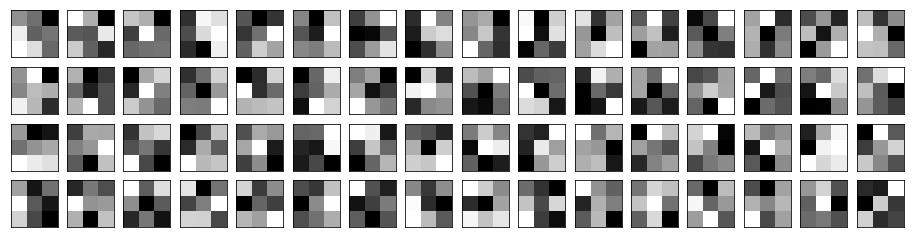

In [49]:
lines = 4
rows = 16
index = 2

p0 = params['lstm.0.conv_c.weight']
fig, axarr = plt.subplots(lines, rows, figsize=(16, 4))

for i in range(lines):
    for k in range(rows):
        a = i * rows + k
        axarr[i, k].imshow(p0[index, a ,:], cmap='gray')
        axarr[i, k].set_yticks([])
        axarr[i, k].set_xticks([])

plt.show()

(array([1.0000e+01, 1.4000e+02, 2.1190e+03, 1.9609e+04, 6.1578e+04,
        5.0991e+04, 1.1897e+04, 1.0480e+03, 5.8000e+01, 6.0000e+00]),
 array([-0.26462987, -0.21023346, -0.15583706, -0.10144066, -0.04704426,
         0.00735214,  0.06174855,  0.11614495,  0.17054135,  0.22493775,
         0.27933416], dtype=float32),
 <a list of 10 Patch objects>)

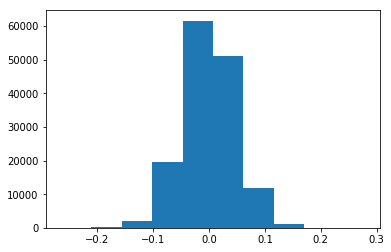

In [71]:
p0 = params['lstm.3.conv_h.weight']
p0b = params['lstm.3.conv_h.bias']
p0f = p0.flatten()
plt.hist(p0f)

(array([ 3.,  3., 20., 36., 63., 46., 52., 18.,  9.,  6.]),
 array([-0.14997448, -0.12555374, -0.101133  , -0.07671225, -0.05229151,
        -0.02787077, -0.00345002,  0.02097072,  0.04539146,  0.0698122 ,
         0.09423295], dtype=float32),
 <a list of 10 Patch objects>)

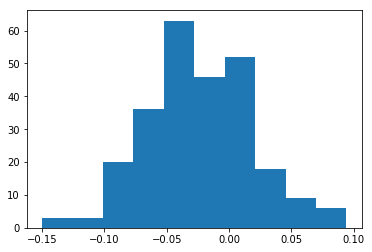

In [72]:
plt.hist(p0b)

# Deconv kernels

In [32]:
p0.squeeze().size()

torch.Size([64, 7, 7])

In [78]:
p0.size()

torch.Size([64, 1, 7, 7])

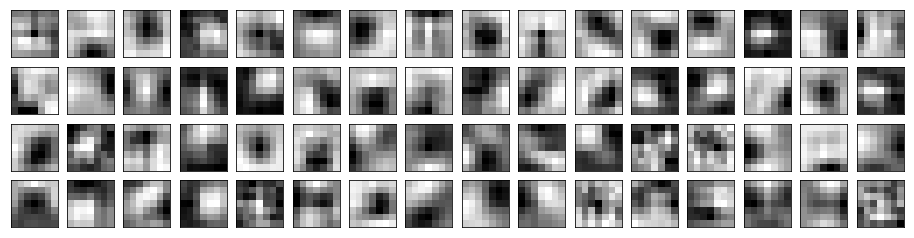

In [87]:
lines = 4
rows = 16
index = 2

p0 = params['deconv.weight'].squeeze()
fig, axarr = plt.subplots(lines, rows, figsize=(16, 4))

for i in range(lines):
    for k in range(rows):
        a = i * rows + k
        axarr[i, k].imshow(p0[a ,:], cmap='gray')# vmin=-0.4, vmax=0.4)
        axarr[i, k].set_yticks([])
        axarr[i, k].set_xticks([])

plt.show()

(array([   3.,    5.,   69.,  465., 1445.,  887.,  225.,   32.,    2.,
           3.]),
 array([-0.54466075, -0.43099856, -0.31733638, -0.20367418, -0.09001199,
         0.0236502 ,  0.13731238,  0.25097457,  0.36463678,  0.47829896,
         0.59196115], dtype=float32),
 <a list of 10 Patch objects>)

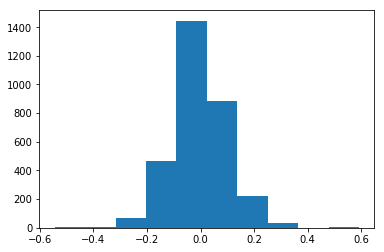

In [85]:
plt.hist(p0.flatten())

In [91]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
#     print(name)
    return hook

for i in range(4):
    model.lstm[i].conv_h.register_forward_hook(get_activation('lstm.%d.conv_h' %i))
    model.lstm[i].conv_c.register_forward_hook(get_activation('lstm.%d.conv_c' %i))
    model.lstm[i].conv_m.register_forward_hook(get_activation('lstm.%d.conv_m' %i))
    model.lstm[i].conv_x.register_forward_hook(get_activation('lstm.%d.conv_x' %i))
    model.lstm[i].conv_o.register_forward_hook(get_activation('lstm.%d.conv_o' %i))
    
model.deconv.register_forward_hook(get_activation('deconv'))

In [222]:
import torch
starting_point = 10
num_total_output_frames = 50
model.eval()
num_input_frames = model.get_num_input_frames()
with torch.no_grad():
    input_end_point = starting_point + num_input_frames
    input_frames = batch_images[:1, starting_point:input_end_point, :, :].clone()
    output_frames = model.get_future_frames(input_frames, num_total_output_frames, belated=True)
    target_frames = batch_images[:1, input_end_point:(input_end_point + num_total_output_frames), :, :]

In [223]:
output_frames = image_prepro(output_frames, experiment.normalizer)
target_frames = image_prepro(target_frames, experiment.normalizer)
input_frames = image_prepro(input_frames, experiment.normalizer)

In [224]:
output_frames.size()

torch.Size([1, 50, 128, 128])

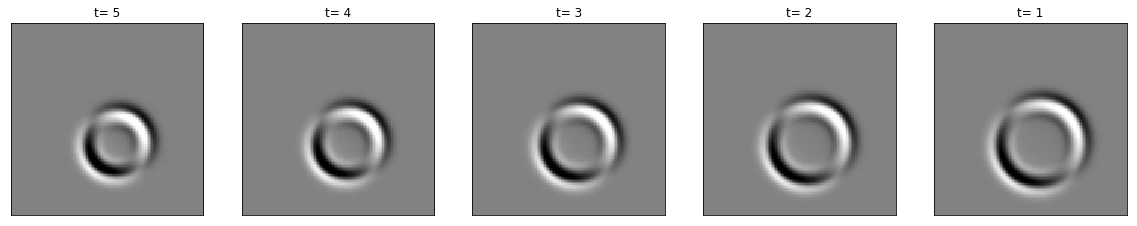

In [225]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for t in range(5):
    ax[t].imshow(input_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
    ax[t].set_title('t= %d' % (5-t))
    ax[t].get_xaxis().set_ticks([])
    ax[t].get_yaxis().set_ticks([])
plt.show()

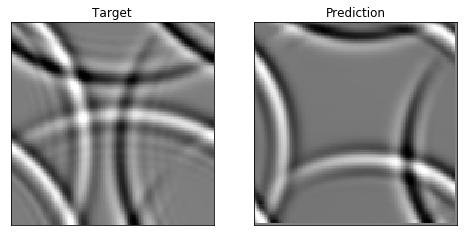

In [226]:
t=num_total_output_frames-1
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].imshow(target_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(output_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Target')
ax[1].set_title('Prediction')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
plt.show()

In [227]:
def print_activations(act_name):
    act = activation[act_name].squeeze()
    print(act.size())

    lines = 8
    rows = 16

    fig, axarr = plt.subplots(lines, rows, figsize=(16, 8))
    for i in range(lines):
        for k in range(rows):
            if (i*lines+k >= act.size(0)):
                continue
            axarr[i, k].imshow(image_prepro(act[i*lines+k,:], experiment.normalizer), cmap='gray', vmin=0, vmax=1)
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])


    plt.show()

torch.Size([256, 31, 31])


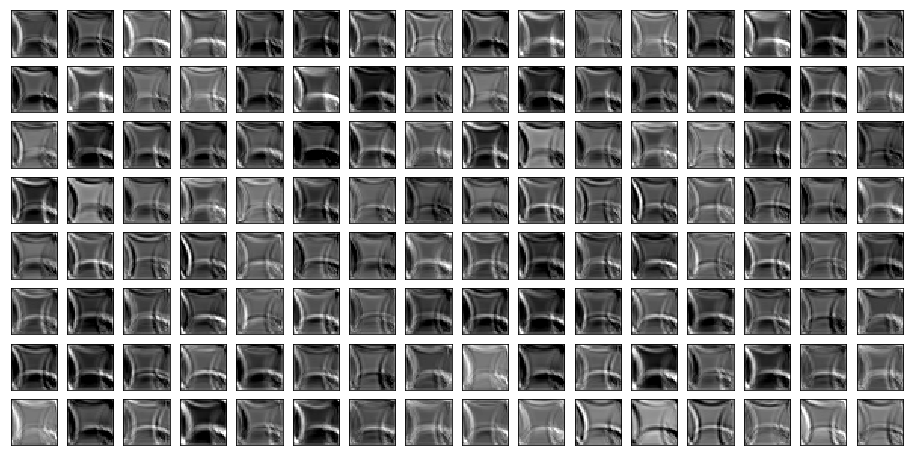

In [228]:
print_activations('lstm.0.conv_h')

torch.Size([256, 31, 31])


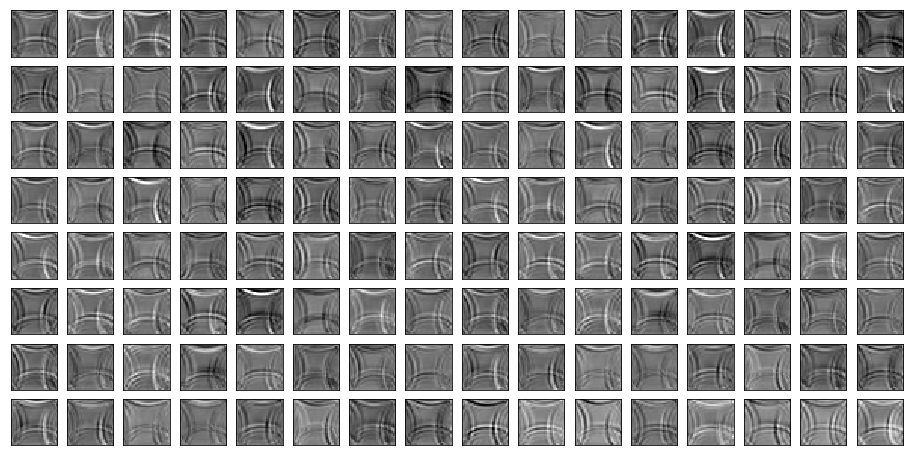

In [229]:
print_activations('lstm.1.conv_h')

torch.Size([256, 31, 31])


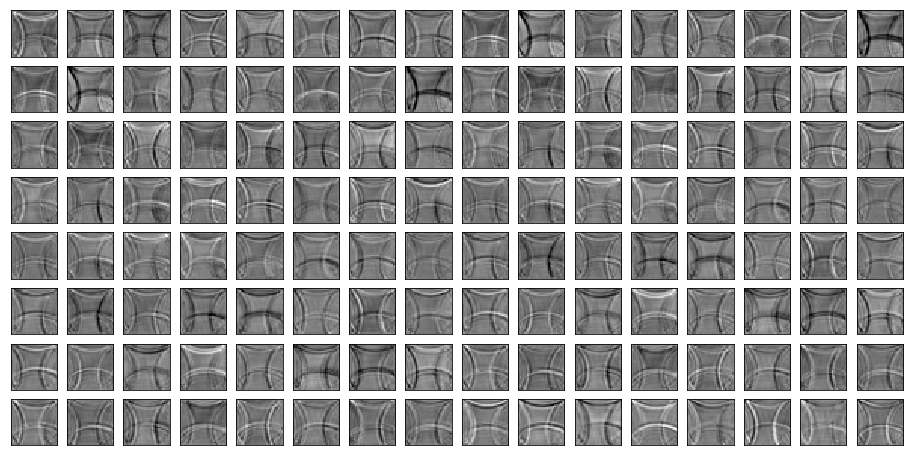

In [230]:
print_activations('lstm.2.conv_h')

torch.Size([256, 31, 31])


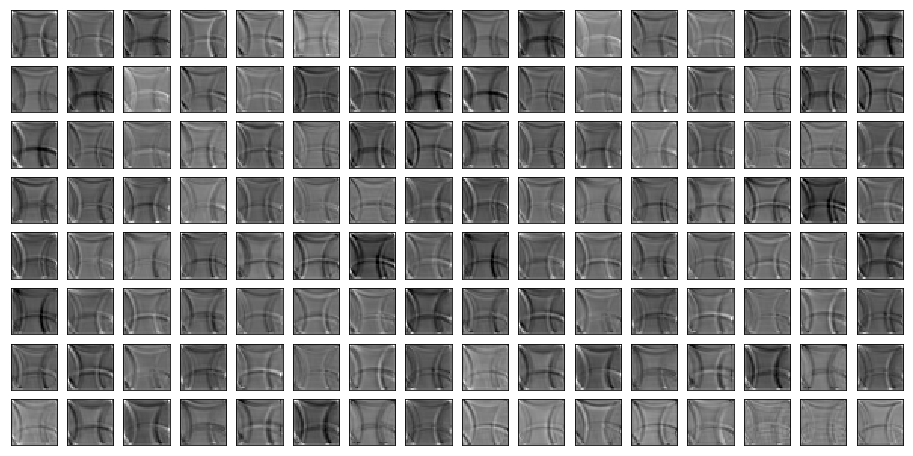

In [231]:
print_activations('lstm.3.conv_h')

In [232]:
#  print_activations('lstm.0.conv_c')

In [233]:
# print_activations('lstm.0.conv_m')

In [234]:
# print_activations('lstm.0.conv_x')

In [235]:
# print_activations('lstm.0.conv_o')

In [239]:
dconv_norm = image_prepro(activation['deconv'].squeeze(), experiment.normalizer)

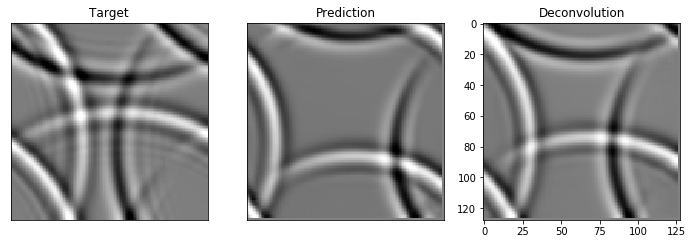

In [240]:
t=num_total_output_frames-1
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].imshow(target_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(output_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[2].imshow(dconv_norm, cmap='gray', vmin=0, vmax=1)
ax[0].set_title('Target')
ax[1].set_title('Prediction')
ax[2].set_title('Deconvolution')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
plt.show()

In [243]:
(output_frames[0, t, :, :] - dconv_norm)

tensor([[-0.0321,  0.0544,  0.1560,  ...,  0.1096,  0.0854,  0.0000],
        [-0.1506, -0.0731,  0.0518,  ...,  0.1527,  0.1247,  0.0000],
        [-0.2784, -0.2198, -0.1033,  ...,  0.1754,  0.1468,  0.0000],
        ...,
        [ 0.2513,  0.3646,  0.4673,  ..., -0.0174, -0.0201,  0.0000],
        [ 0.1776,  0.3013,  0.4205,  ..., -0.0113, -0.0132,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])